In [1]:
import numpy as np
import h5py as h5

import scipy as scp
import sklearn as skl
import matplotlib.pyplot as plt
import keras 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from skimage.measure import block_reduce

from keras.models import Sequential, Model
from keras.layers import Dense, GaussianNoise, Input, Conv2D, Flatten, MaxPooling2D, Dropout, Conv2DTranspose, Reshape
from keras.regularizers import l2

from mlhelpers4 import PlotLosses, plot_a_bunch_of_beams,make_dataset
plot_losses=PlotLosses()
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'font.size': 10})
#plt.style.use('rs_paper.mplstyle')
import time

In [2]:
############# set these according to which offsets you want to run. 
############# If the file does not exist, you'll need to go run it in SRW_multiprocess.py 
offsets_mirror1 = True
offsets_mirror2 = True
rotations_mirror1 = True 
rotations_mirror2 = True
n_runs = 10000

input_str = 'datasets/beam_intensities_'
output_str = 'datasets/parameters_'
save_str = 'results/'
data_str = '' 
if offsets_mirror1:
    save_str += 'mirror1_offsets_'
    data_str += 'mirror1_offsets_'

if offsets_mirror2:
    save_str += 'mirror2_offsets_'
    data_str += 'mirror2_offsets_'

if rotations_mirror1:
    save_str += 'mirror1_rotations_'
    data_str += 'mirror1_rotations_'

if rotations_mirror2: 
    save_str += 'mirror2_rotations_'
    data_str += 'mirror2_rotations_'
    
images = np.load(input_str + data_str + str(n_runs) + 'runs.npy')
images.reshape(list(images.shape).append(1))
settings = np.load(output_str + data_str + str(n_runs) + 'runs.npy').reshape(n_runs, -1)
print(images.shape)
print(settings.shape)

(10000, 280, 280)
(10000, 6)


### Reduce the Image Size

The raw data images are 280 x 280, which means a lot of pixels with zero information in them. We try downsampling the images to be smaller to make the training a bit faster.

In [3]:
block_size = 8
new_im = block_reduce(images, block_size=(1,block_size, block_size), func=np.mean)
new_im /= np.amax(new_im)
print('new data shape = {}'.format(new_im.shape))
image_shape = new_im.shape[1:]

new data shape = (10000, 35, 35)


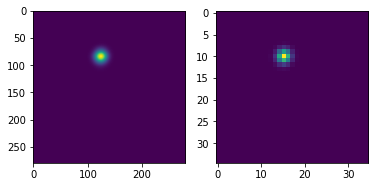

In [4]:
fig, [ax1, ax2] = plt.subplots(1,2)
ax1.imshow(images[0])
ax2.imshow(new_im[0])

In [5]:
############# sets labels for automated plots for results 
labels = []
if offsets_mirror1:
    labels.append('dx1')

if offsets_mirror2:
    labels.append('dy2')

if rotations_mirror1: 
    #labels.append('thetax1')
    labels.append('thetay1')
    labels.append('thetaz1')
    
if rotations_mirror2: 
    labels.append('thetax2')
    #labels.append('thetay2')
    labels.append('thetaz2')

print(labels)
print(save_str)

['dx1', 'dy2', 'thetay1', 'thetaz1', 'thetax2', 'thetaz2']
results/mirror1_offsets_mirror2_offsets_mirror1_rotations_mirror2_rotations_


In [6]:
############# normalize parameter offsets 
transformer_y = RobustScaler().fit(settings)
Y_scaled = transformer_y.transform(settings)
print(np.max(Y_scaled))
print(np.min(Y_scaled))

1.0068269630417783
-1.0067199539492877


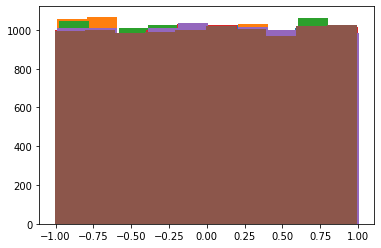

In [7]:
############# beautiful plot to make sure you actually normalized everything 
for i in range(Y_scaled.shape[1]):
    plt.hist(Y_scaled[:, i])
plt.show()

In [8]:
############# split train/test data 
split = 80
new_im = new_im.reshape(new_im.shape[0],new_im.shape[1], new_im.shape[2],1)
y_train, y_val, x_train, x_val = train_test_split(Y_scaled, new_im, 
                                                test_size = (100 - split) / 100.,
                                                random_state = 42)

## Model

In [9]:
# convolutional layers
conv_layer = {}
conv_layer['layer_1'] = [5, 32]
#conv_layer['layer_2'] = [3, 32]
kernel_sizes = [5, 3]
filters = [32, 32]

# layers
layer_size = [20]
layer_type = ['relu']

# check that we didn't mess this up
assert len(layer_size) == len(layer_type)

# gaussian noise regularization
noise_level = .0001

In [10]:
model = Sequential() ## initial feed forward model 
print(x_train.shape)
for key in conv_layer.keys():
    model.add(Conv2D(filters=conv_layer[key][1], kernel_size=conv_layer[key][0],
                    input_shape=(x_train.shape[1:]),  kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
    model.add(MaxPooling2D())
    
model.add(Flatten())     ## because outputs are scalar we need to flatten our conv layer 
model.add(Dropout(0.3))

for idx, size in enumerate(layer_size):
    model.add(Dense(size, 
                    activation=layer_type[idx],
                    kernel_regularizer=l2(l=0.00001))) #, kernel_regularizer=keras.regularizers.l2(l=0.0001)
    #model.add(GaussianNoise(noise_level))
    
# add the output layer
model.add(Dense(y_train.shape[1], 
                activation='linear'))

opt = keras.optimizers.Adam()
    
model.compile(optimizer=opt, loss='mean_squared_error') ## setup the optimizer and loss function
model.summary()

(8000, 35, 35, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                144020    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 144,978
Trainable params: 144,978
Non-trainable params: 0
________________________________

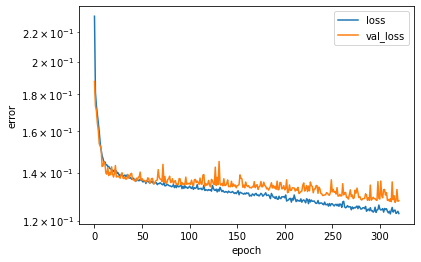

Epoch 322/500


In [ ]:
n_epochs = 500
start = time.time()
hist = model.fit(x=x_train, y=y_train, 
                validation_data= (x_val, y_val),
                 batch_size = 128,
                 shuffle = 'true',
                 epochs = n_epochs,
                 verbose = 'false',
                 callbacks = [plot_losses])
end = time.time()
print('Time to train model: ' + str((end - start)/60) + ' minutes')

In [ ]:
plt.figure()
plt.ylabel('error')
plt.xlabel('epochs')
plt.plot(hist.epoch, hist.history['val_loss'], label='test')
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.legend(loc='best')
plt.savefig(save_str + 'lossplot.png')
plt.show()

# Eval Model

In [ ]:
fig, axs = plt.subplots(1, np.shape(y_val)[1], figsize=(16, 6))
preds = model.predict(new_im)
errs = np.sqrt(np.mean((Y_scaled - preds)**2, axis=1))

for idx in range(np.shape(y_val)[1]):
    axs[idx].hexbin(Y_scaled[:,idx], errs, cmap = 'bone_r')
    #axs[idx].set_xlabel(y_labels[idx])
    axs[idx].set_ylabel('errs')
fig.tight_layout()
fig.savefig('rms_model_errs_corr.png')